# Modelling Wind Speed and Direction Distribution using Gaussain Mixture Modles (Harris and Cook's OEN method)

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Modles, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from IPython.display import display

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn
import re

import statsmodels.api as sm
import seaborn as sns
sns.set_style('whitegrid')

from scipy import integrate
from sklearn import mixture, neighbors
from numpy import inf, arange, array, linspace, exp, log, power, pi, cos, sin, radians

from windrose import WindroseAxes, WindAxes

from helpers.utility_helper import *
from helpers.app_helper import *
from helpers.gmm_helper import *
from helpers.plot_helper import *
from helpers.data_reader import *

## 1.2 Read Data

In [2]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # weird shape at 3, try 4
# ipath= './data/NCDC/tiree.txt'
ipath= "./data/NCDC/marham.txt"

# ipath= "./data/NCDC/cheongju_intl/dat.txt"
# ipath= "./data/NCDC/daegu_ab/dat.txt" # recent 5 year data is corrupted

# ipath= "./data/NCDC/canada/st_johns_intl/dat.txt" # good
# ipath= "./data/NCDC/canada/gander_intl/dat.txt" # try 4
# ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt"  # lacks inital speed
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 
# ipath= "./data/NCDC/canada/argentia/dat.txt" # weird shape

# ipath= './data/NCDC/europe/ciampino/dat.txt' # Italy
# ipath= "./data/NCDC/europe/laupheim/dat.txt"
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt"
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak, try 4
# ipath= "./data/NCDC/europe/avord/dat.txt" # double peak. try square error, 4, very good
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better
# ipath= "./data/NCDC/europe/barayas/dat.txt" # try 4, still bad fit
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer

# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # India, not very good

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt" # unable to chi square
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # sectors are 16

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # bad fit
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape

# ipath= "./data/NCDC/cn/luogang/dat.txt"  # good, try 4
# ipath= "./data/NCDC/cn/南京lukou/dat.txt" # good
# ipath= "./data/NCDC/cn/binhai/dat.txt" # good, but recent 5 year data may have been corrupted, 05-09 is good
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # 
# ipath= "./data/NCDC/cn/武汉tianhe/dat.txt" # 
# ipath= "./data/NCDC/cn/wusu/dat.txt" # not quite good, try 4?
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/yueyang/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/wuxu/dat.txt" # unable to fit with chi square
# ipath= "./data/NCDC/cn/广州baiyun/dat.txt" # Is this dataset correct?
# ipath= "./data/NCDC/cn/zhengding/dat.txt" #  Initial data is weird

# ipath= "./data/NCDC/cn/baoan_intl/dat.txt" # good, but 1个方向的数据过少，很难拟合
# ipath= "./data/NCDC/cn/上海/虹桥/dat.txt" # good
# ipath= "./data/NCDC/cn/上海/上海/dat.txt"  
# ipath= './data/NCDC/macau/dat.txt' # not good, feels like truncate data, try 4
# ipath= "./data/NCDC/hk_intl/dat.txt" # truncate dataset

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted
# ipath= "./data/NCDC/us/sacramento_arp/dat.txt"  # truancate data
# ipath= "./data/NCDC/us/st_louis_arp/9511346969491dat.txt"  
# ipath= './data/NCDC/us/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/us/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/us/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/us/newark/8455636958433dat.txt'
# ipath= './data/NCDC/us/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/us/olympia_airport/2647036962786dat.txt" 
# ipath= "./data/NCDC/us/sidney/6062326959357dat.txt" 
# ipath= "./data/NCDC/us/general_mitchell_intl/dat.txt"

# not sample as %5, e.g. sampling time is 1852
# ipath= "./data/NCDC/us/quad_city_arp/dat.txt" 

# ipath= "./data/cn_database/上海baoshan.txt"
# ipath= "./data/cn_database/beijing.txt"
# ipath= "./data/cn_database/xiamen.txt"
# ipath= "./data/cn_database/hefei.txt"
# ipath= "./data/cn_database/lasa.txt"
# ipath= "./data/cn_database/lenghu.txt"

## Problem dataset
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # recent year speed wired
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 
# ipath= "./data/NCDC/cn/长沙huanghua/dat.txt" # direction may not be real

uipath = unicode(ipath , "utf8")
cn_database = False

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)
    cn_database = True

In [3]:
# select year 1945-2014, dir < 999, speed<999
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) & \
              (HrMn % 5 == 0 )")

df.index= df['date']
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360)
df.describe()

,date,HrMn,dir,speed
count,447243.000000,447243.000000,447243.000000,447243.000000
mean,19998783.907153,1168.281851,184.857391,4.739733
std,101492.086192,688.968703,93.912703,2.699617
min,19800101.000000,0.000000,0.000000,0.500000
25%,19910701.000000,600.000000,120.000000,2.600000
50%,20020116.000000,1200.000000,200.000000,4.100000
75%,20090227.000000,1750.000000,250.000000,6.200000
max,20150801.000000,2355.000000,350.000000,28.000000


True


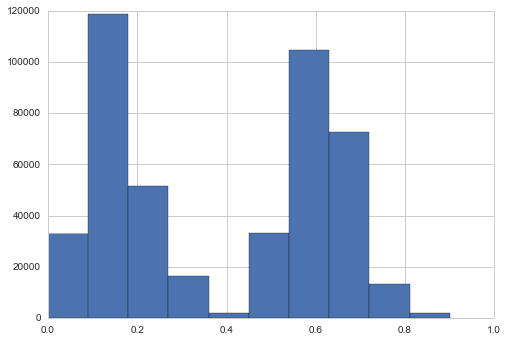

In [4]:
# Detect data stored in knot or m/s
df['decimal'] = df.speed % 1 
df.decimal.hist()
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

print knot_unit

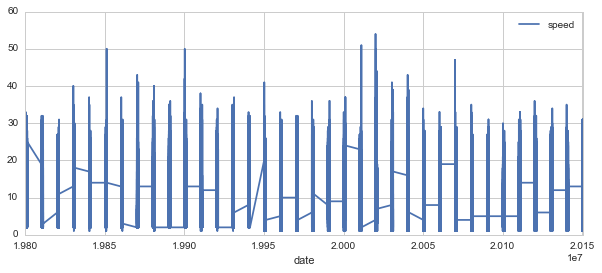

In [5]:
# Using unit in knot instead of m/s
# need more elaboration, some is not near an integer
if knot_unit:
    df.rename(columns={'speed':'speed_mps'}, inplace=True)
    df['speed']=df['speed_mps']
    df['speed']=df['speed_mps']*1.943845
    df['speed']=df['speed'].apply(lambda x: int(round(x)))

df['speed'].plot(legend=True,figsize=(10,4), grid=True)

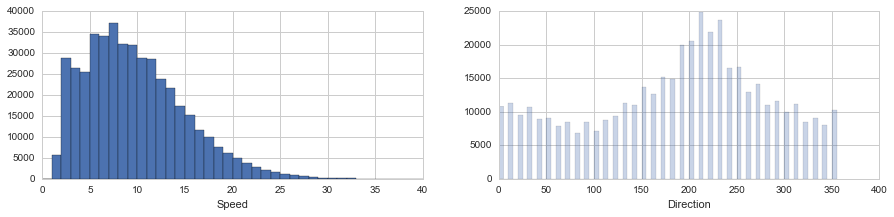

In [6]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

,date,HrMn,type,dir,speed_mps,decimal,speed,incre,incre_reverse
date,,,,,,,,,
20020128,20020128,1700,FM-12,240,28.0,0.0,54,26,27
20011228,20011228,1400,FM-12,280,26.0,0.0,51,25,30
20020304,20020304,50,FM-15,40,25.7,0.7,50,44,46
19851113,19851113,900,FM-12,220,25.7,0.7,50,40,45
19900223,19900223,1000,SY-MT,290,25.7,0.7,50,43,45
20070118,20070118,1250,FM-15,270,24.2,0.2,47,17,0
20070118,20070118,1300,FM-12,270,24.2,0.2,47,0,12
20021027,20021027,1000,FM-12,250,22.6,0.6,44,10,32
20070118,20070118,1500,FM-12,270,22.1,0.1,43,0,3


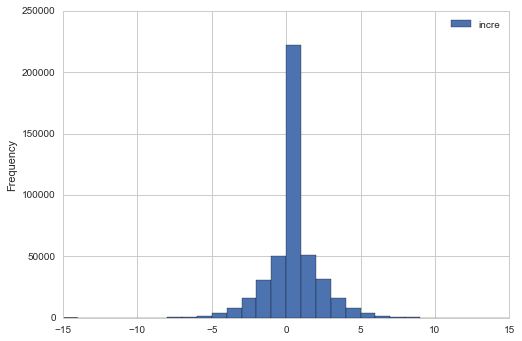

In [7]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
display(df.sort_values(by='speed',ascending=False).head(10))
bins=arange(-15, 15 + 1, 1)
df['incre'].plot(kind='hist', bins=bins, legend=True)

In [8]:
# Simple Artefacts Handling
incre_threshold = 20 if knot_unit else 10
df = df.query('(incre < @incre_threshold )&(incre_reverse < @incre_threshold )')
df = df.query('dir % 10 <= 0.1')

After Simple Aretefacts Handling

In [9]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed_mps,decimal,speed,incre,incre_reverse
date,,,,,,,,,
20070118,20070118,1250,FM-15,270,24.2,0.2,47,17,0
20070118,20070118,1300,FM-12,270,24.2,0.2,47,0,12
20070118,20070118,1450,FM-15,270,22.1,0.1,43,8,0
20070118,20070118,1500,FM-12,270,22.1,0.1,43,0,3
20040320,20040320,1600,FM-12,250,22.1,0.1,43,3,8
19900226,19900226,700,FM-12,230,22.1,0.1,43,9,18
19870327,19870327,1400,SY-MT,220,22.1,0.1,43,7,3
19900125,19900125,1650,FM-15,250,21.6,0.6,42,3,0
19900125,19900125,1700,SY-MT,250,21.6,0.6,42,0,4


### 1.3.2 Sampling Time Selection

In [10]:
df['HrMn'].value_counts().sort_index()

0       12102
5           3
10          3
15          1
20          5
25          2
30         10
35          1
50       6107
55          1
100     12155
105         1
110         1
120         5
130         3
135         2
150      6212
155         1
200     12123
205         2
220         8
225         1
230         9
240         1
245         2
250      6289
255         2
300     12025
310         3
315         1
        ...  
2045        2
2050     6117
2100    12177
2105        1
2110        2
2115        4
2120        3
2125        1
2130        5
2140        2
2145        2
2150     6111
2155        1
2200    12213
2205        1
2210        1
2220        5
2225        2
2230        2
2235        1
2250     6217
2300    12242
2305        2
2315        1
2320        8
2325        2
2330        9
2345        2
2350     6318
2355        5
Name: HrMn, dtype: int64

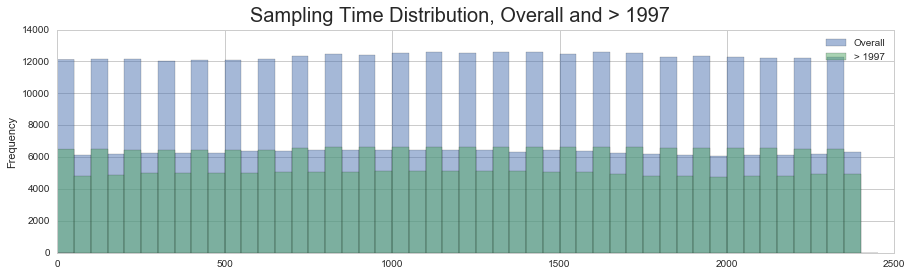

In [11]:
# Ensure data sampled equally
mid_year = int(((min(df.date)+max(df.date))/2 )/10000)
bins=arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @mid_year * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  mid_year )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  mid_year, fontsize = 20)
plt.legend()

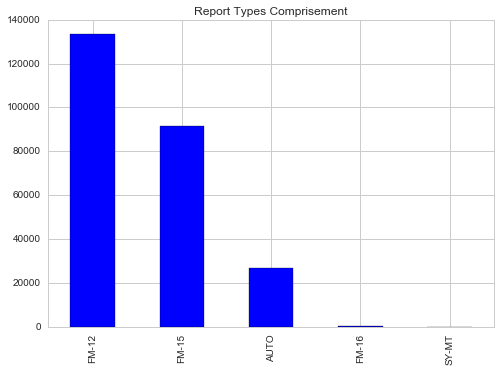

In [12]:
df.query("date >= 20000000 ")['type'].value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = df.query("date >= 20000000 ")['type'].value_counts().argmax()

In [13]:
# Data Selection
if "ciampino" in ipath: 
    df = df[(df['HrMn'] % 100 == 15)|(df['HrMn'] % 100 == 45)|(df['HrMn'] % 100 == 20)|(df['HrMn'] % 100 == 50)]
else: 
    df = df.query('HrMn % 5 <= 0.1')

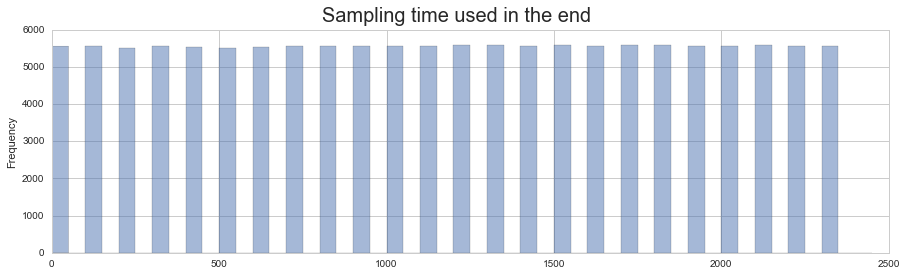

In [14]:
# We're gonna use the most frequent report type, here is its distirbution
df = df.query("type==@report_type_most_used")

df.query('date > 20000000')['HrMn'].plot(
    kind='hist', alpha=0.5, figsize=(15, 4), bins=bins)

plt.suptitle('Sampling time used in the end', fontsize = 20)

## 1.3.3 Time Shift Comparison

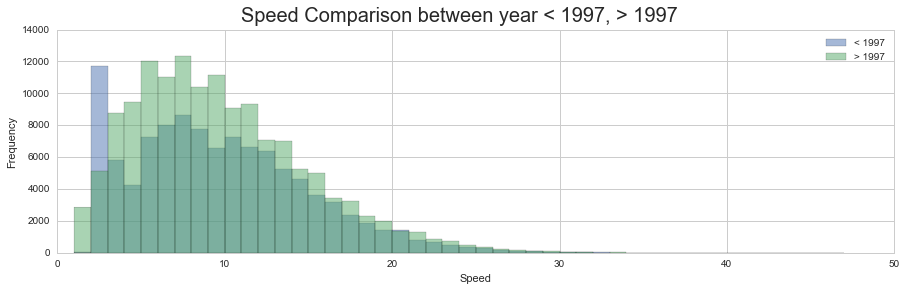

In [15]:
mid_year = int(((min(df.date)+max(df.date))/2 )/10000)

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(min(df.speed), max(df.speed) + 1, 1)
df[df['date'] < mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

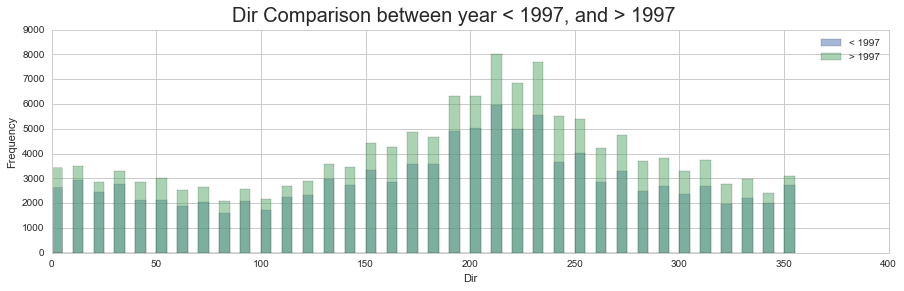

In [16]:
bins=arange(min(df.dir), max(df.dir) + 10, 5)
df[df['date'] < mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

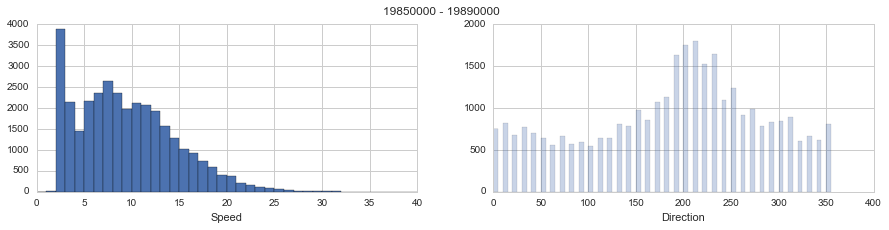

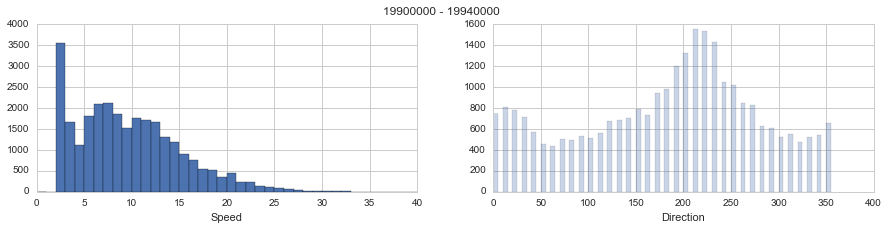

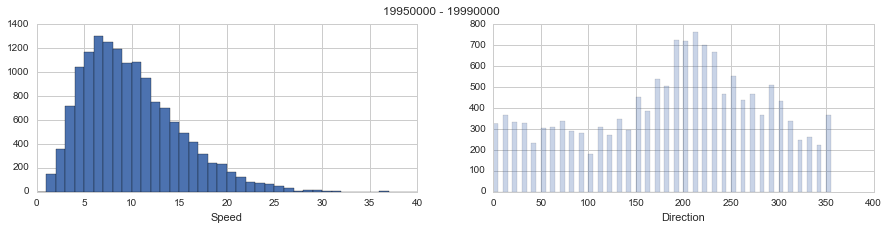

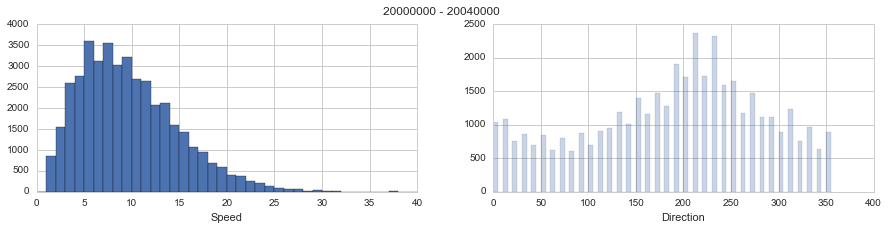

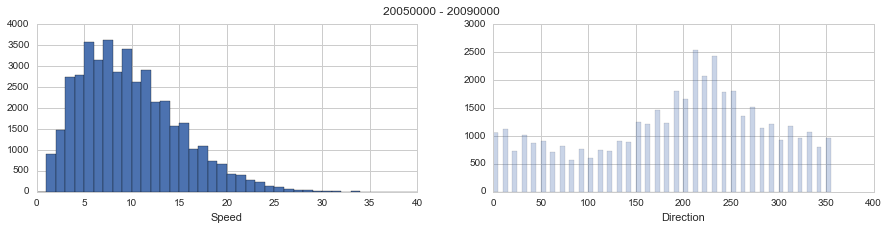

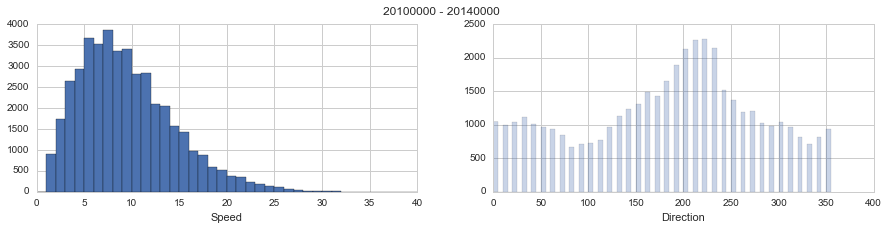

In [17]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = '%s - %s' %(start_time, end_time-10000)
            plot_speed_and_angle_distribution(sub_df, title)
        
check_time_shift(df)

## 1.4 Re-select data, data conversion, and overview of the clean dataset

In [18]:
# Year range, Reports Type, Sampling Time
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

,date,HrMn,dir,speed_mps,decimal,speed,incre,incre_reverse
count,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000
mean,20120645.524869,1151.265925,180.880503,4.616530,0.392971,8.974843,0.000000,-0.002488
std,14137.962482,692.052220,93.708645,2.566499,0.261506,4.986154,0.160058,2.101477
min,20100101.000000,0.000000,0.000000,0.500000,0.000000,1.000000,-7.000000,-18.000000
25%,20110402.000000,600.000000,120.000000,2.600000,0.100000,5.000000,0.000000,-1.000000
50%,20120629.000000,1200.000000,190.000000,4.100000,0.500000,8.000000,0.000000,0.000000
75%,20130930.000000,1800.000000,250.000000,6.200000,0.600000,12.000000,0.000000,1.000000
max,20141231.000000,2300.000000,350.000000,18.500000,0.900000,36.000000,7.000000,15.000000


### 1.4.1 Overview

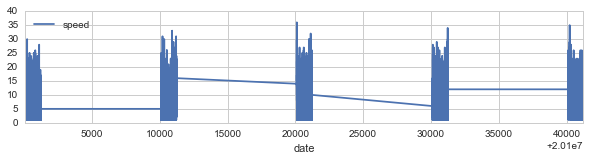

In [19]:
df['speed'].plot(legend=True,figsize=(10,2), grid=True)

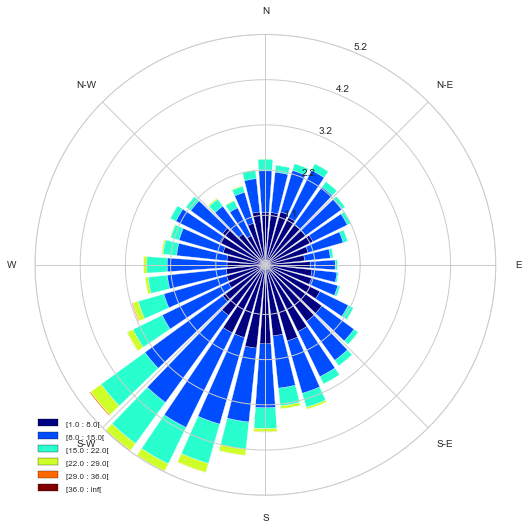

In [20]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

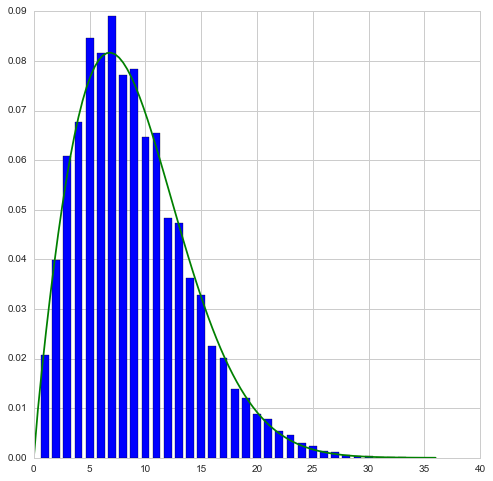

In [21]:
ax = WindAxes.from_ax()
bins=arange(min(df.speed), max(df.speed) + 1, 1)
ax, _ = ax.pdf(df.speed, bins = bins)
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)

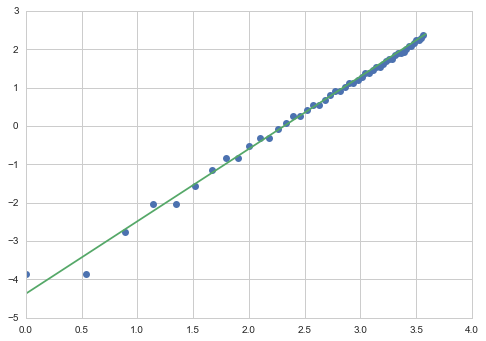

In [22]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-')

### 1.4.2 Direction Conversion, from windrose to polar system
e.g. 0 degree = north, clockwise => 90 degree = north, counterclockwise

In [23]:
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)
df['dir'].value_counts().sort_index()

0       712
10      674
20      845
30      939
40      973
50     1017
60     1113
70     1042
80      993
90     1048
100     944
110     816
120     712
130     815
140     972
150    1047
160     982
170    1032
180    1204
190    1195
200    1372
210    1522
220    2146
230    2277
240    2273
250    2136
260    1894
270    1653
280    1431
290    1485
300    1312
310    1235
320    1134
330     968
340     768
350     726
Name: dir, dtype: int64

In [24]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

In [25]:
df.describe()

,date,HrMn,dir,speed_mps,decimal,speed,incre,incre_reverse
count,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000
mean,20120645.524869,1151.265925,191.524639,4.616530,0.392971,8.974843,0.000000,-0.002488
std,14137.962482,692.052220,95.092684,2.566499,0.261506,4.986154,0.160058,2.101477
min,20100101.000000,0.000000,0.000000,0.500000,0.000000,1.000000,-7.000000,-18.000000
25%,20110402.000000,600.000000,110.000000,2.600000,0.100000,5.000000,0.000000,-1.000000
50%,20120629.000000,1200.000000,210.000000,4.100000,0.500000,8.000000,0.000000,0.000000
75%,20130930.000000,1800.000000,260.000000,6.200000,0.600000,12.000000,0.000000,1.000000
max,20141231.000000,2300.000000,350.000000,18.500000,0.900000,36.000000,7.000000,15.000000


### 1.4.3 Re-distribute Direction, within each sector (optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [26]:
SECTOR_LENGTH = 360/len(effective_coloumn)
print len(effective_coloumn), SECTOR_LENGTH

def randomize_angle(df, sector_length = 10):
    df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2))% 360)

    bins=arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

36 10.0


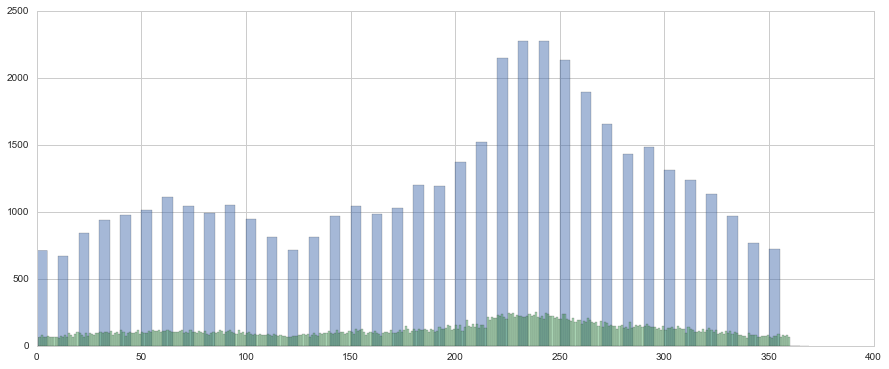

In [27]:
# Randomize the angle degree, to form a better KDE estimation
df['dir_int'] = df['dir']
df = randomize_angle(df, SECTOR_LENGTH)

In [28]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)

    bins=arange(0, df.speed.max(), 1)
    df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=arange(0, df.speed.max(), 0.5)
    df['speed_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

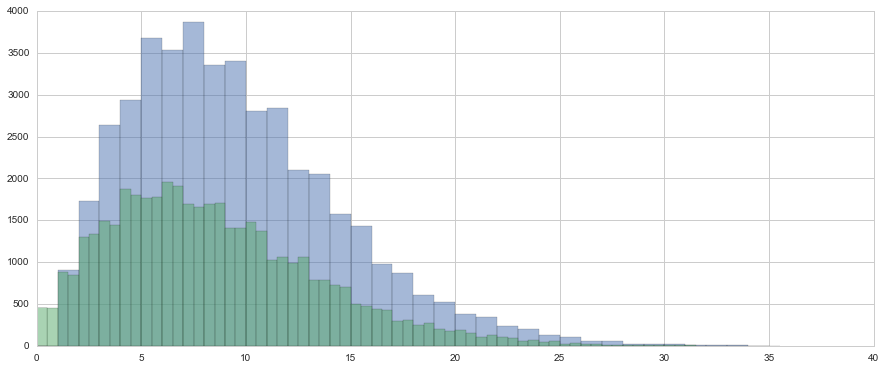

In [29]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df['speed_int'] = df['speed']
df = randomize_speed(df)

### 1.4.4 Generate (x,y) from (speed,dir)

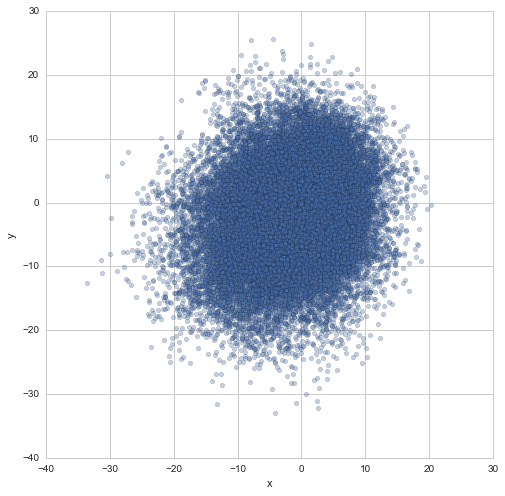

In [30]:
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)

# 2. Create input data, i.e. speed_set

In [31]:
# speed_set = array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
speed_set = array(zip(df.x, df.y))
speed_angle_set = array(zip(df.speed, df.dir))
max_speed = df.speed.max()
NUMBER_OF_GAUSSIAN = 3

In [32]:
FITTING_RANGE = []
if knot_unit == True:
    fitting_axis_range = arange(-20, 21, 1)
    PLOT_AXIS_RANGE = arange(-25, 25, 1)
else:
    fitting_axis_range = arange(-10, 11, 1)
    PLOT_AXIS_RANGE = arange(-10, 11, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

# 3. Kernel Density Estimation

In [33]:
sample = speed_set

In [34]:
# # The bandwidth value would be too radical, so we forsake this approach
# from sklearn.grid_search import GridSearchCV
# grid = GridSearchCV(neighbors.KernelDensity(),
#                     {'bandwidth': linspace(0.1, 1.0, 15)},
#                     n_jobs=-1, cv=4) 
# grid.fit(sample)
# print grid.best_params_
# kde = grid.best_estimator_

In [35]:
bandwidth = 1 if knot_unit else 0.5  # for wuhan, 0.4 is better
kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print kde_result[:5]
print len(kde_result)

[  1.43859823e-05   1.52763237e-05   2.67189097e-05   4.16109457e-05
   5.11016738e-05]
1681


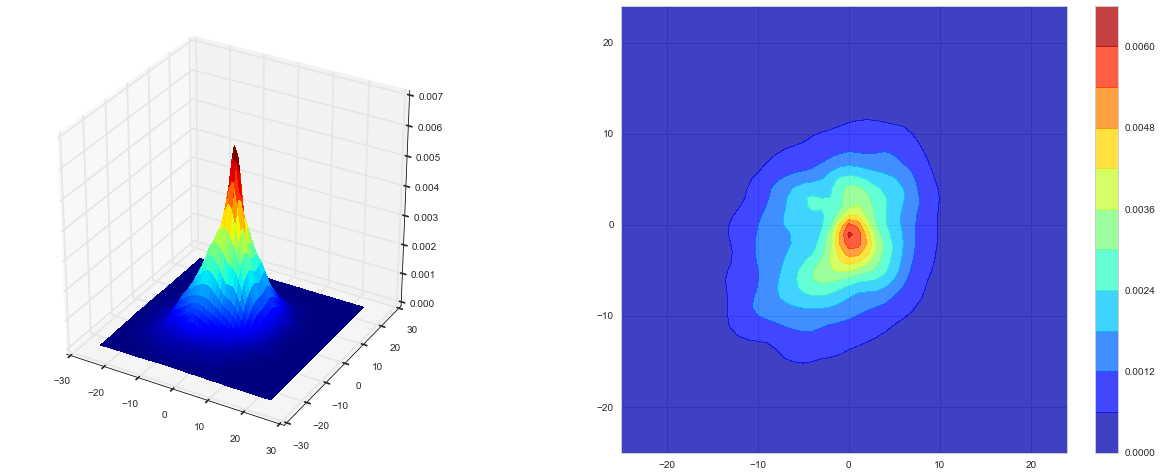

In [36]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [37]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [38]:
sample= speed_set
clf = mixture.GMM(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)

clf.converged_

True

In [39]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.371894,1.198597,-3.344665,4.832983,5.948443,0.170568
1,0.337423,-0.472261,2.716120,5.508009,5.713232,0.064173
2,0.290683,-6.657862,-5.487954,6.254518,6.794061,0.095556


GMM Plot Result
0.371894483325 [[ 1.19859682 -3.34466501]] [ 4.64884846  6.09343166] 160.401658627
0.337422676355 [[-0.47226098  2.71612   ]] [ 5.40045928  5.81500016] 149.845296729
0.29068284032 [[-6.65786185 -5.48795386]] [ 6.10452254  6.92914582] 155.461290435


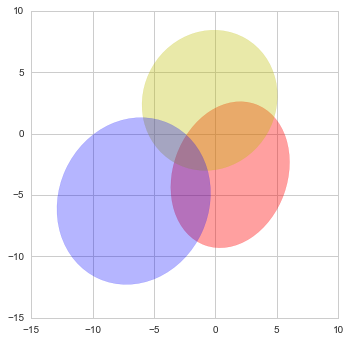

In [40]:
plot_gmm_ellipses(gmm_em_result)

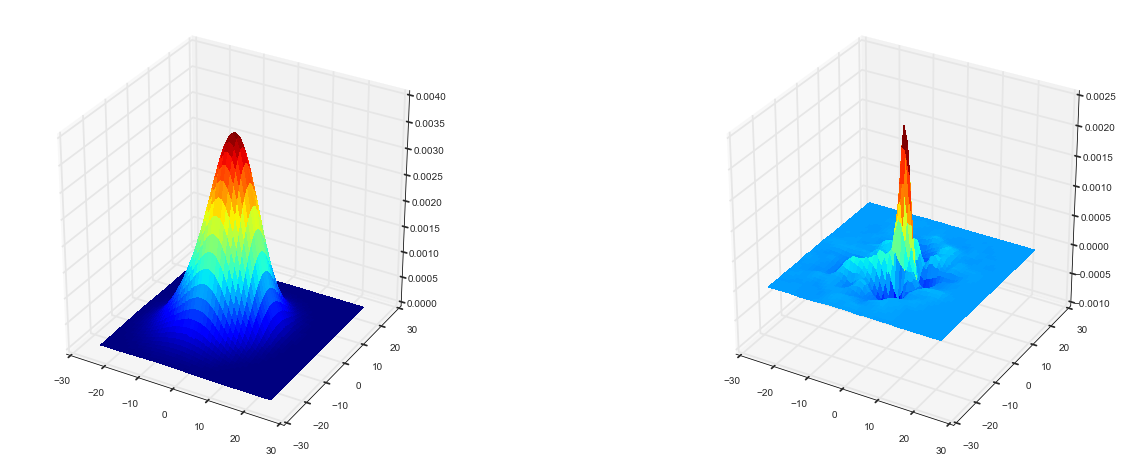

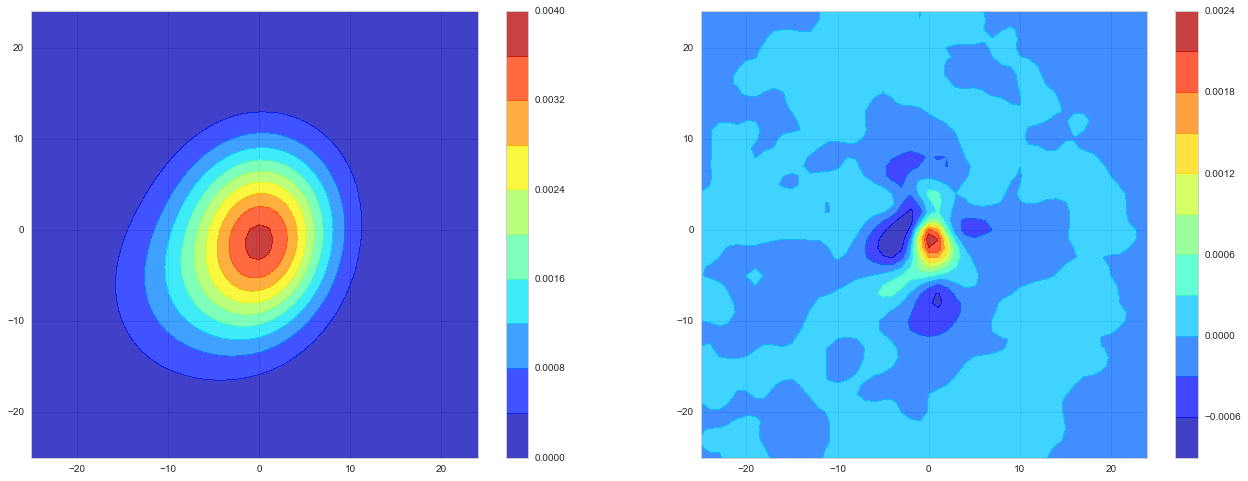

In [41]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points)[0])
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)

## GMM, EM VS. KDE

In [42]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points)[0])

In [43]:
# put into Pandas to make it looks better
pd.DataFrame([goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.03682,0.015774,4.112528e-08,0.033133,0.345128,0.949825


# 5. Least Square Prob Estimation

In [44]:
sample = speed_set
points = FITTING_RANGE

In [45]:
def GMM_fit_score(gmm, kde_result, method = 'square_error'): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Fit the model using different metrics
    gmm_pdf_result = mixed_model_pdf(points)
    if method == 'square_error':
        # 2.1 Square error
        error_array = power(gmm_pdf_result - kde_result,2)
        result = mse_log = log(np.average(error_array))
    elif method == 'chi_square':
        # 2.2 Chi square
        error_array = power(gmm_pdf_result - kde_result,2)
        # unable to * count = 43412, use normalized chi square
        result = chi_square_stat = log(sum(error_array/gmm_pdf_result))
    elif method == 'K_S':
        # 2.3 K-S statistc
        gmm_cdf = cdf_from_pdf(gmm_pdf_result)
        diff = abs(gmm_cdf - kde_cdf)
        result = KS_stat = log(np.amax(diff))
    return result

# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
    # sum of every 6th element, which is the fraction of each gaussian
    {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
    # limit the width/height ratio of elliplse, optional
#     {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#     {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
FIT_METHOD = 'square_error'
result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -18.277033829251799
     jac: array([  7.78032541e-01,   0.00000000e+00,   2.38418579e-07,
         0.00000000e+00,   0.00000000e+00,   2.38418579e-07,
         7.78030634e-01,   2.38418579e-07,   2.38418579e-07,
         2.38418579e-07,   0.00000000e+00,   9.53674316e-07,
         7.78032541e-01,   0.00000000e+00,   2.38418579e-07,
         2.38418579e-07,  -2.38418579e-07,   4.76837158e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1318
     nit: 65
    njev: 65
  status: 0
 success: True
       x: array([ 0.05264199,  0.46236811, -1.71043454,  1.3668296 ,  2.21269665,
        0.0762433 ,  0.50034163, -5.30256674, -3.22102437,  5.67563979,
        7.76754216,  0.16707449,  0.44701638,  2.22436454, -0.44693595,
        4.56348434,  6.55469757,  0.11561792])

## LRMSE VS. KDE

In [46]:
kde_result[:5]

array([  1.43859823e-05,   1.52763237e-05,   2.67189097e-05,
         4.16109457e-05,   5.11016738e-05])

In [47]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.500342,-5.302567,-3.221024,5.675640,7.767542,0.167074
1,0.447016,2.224365,-0.446936,4.563484,6.554698,0.115618
2,0.052642,0.462368,-1.710435,1.366830,2.212697,0.076243


GMM Plot Result
0.500341628212 [[-5.30256674 -3.22102437]] [ 5.51366541  7.88334269] 166.176423618
0.447016383876 [[ 2.22436454 -0.44693595]] [ 4.50529838  6.59482646] 171.324812664
0.0526419879115 [[ 0.46236811 -1.71043454]] [ 1.36042746  2.21663861] 175.669802643


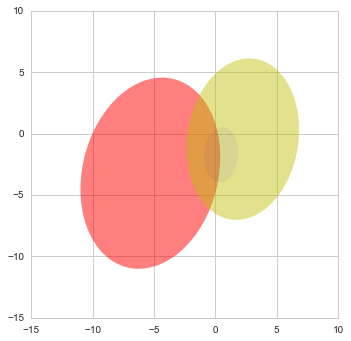

In [48]:
plot_gmm_ellipses(gmm)

## Goodness-of-fit indicators

In [49]:
pd.DataFrame(
    [goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.021629,0.011945,1.154476e-08,0.017555,0.18286,0.985915


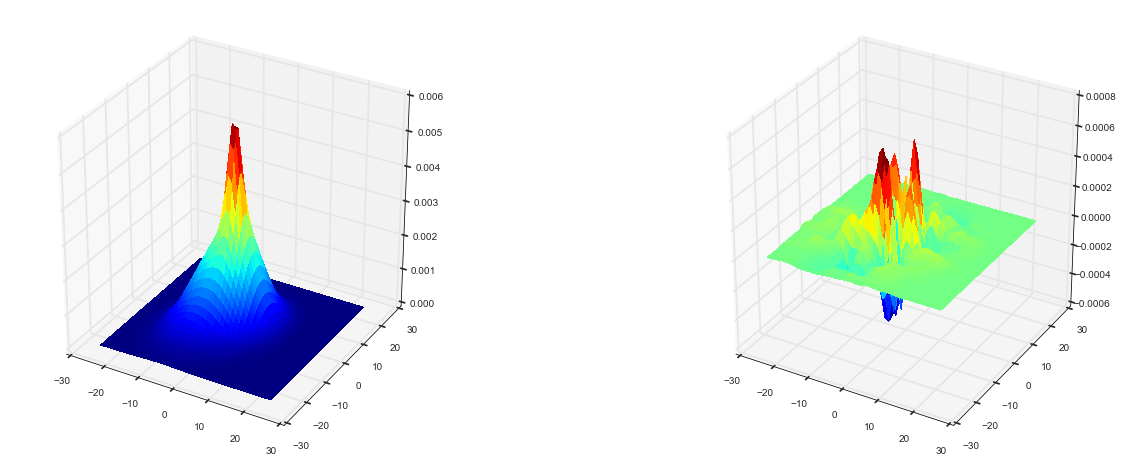

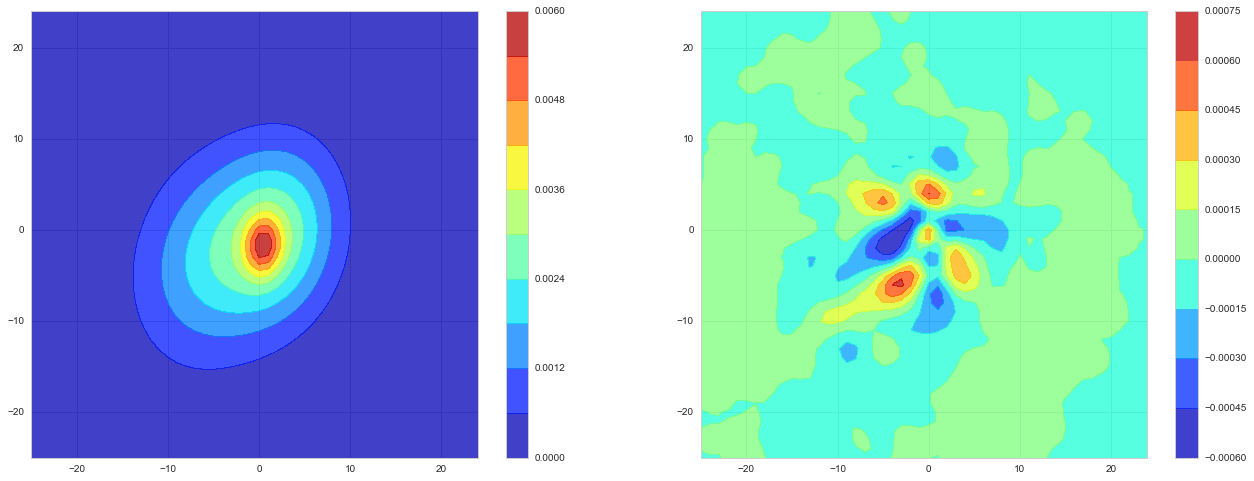

In [50]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)

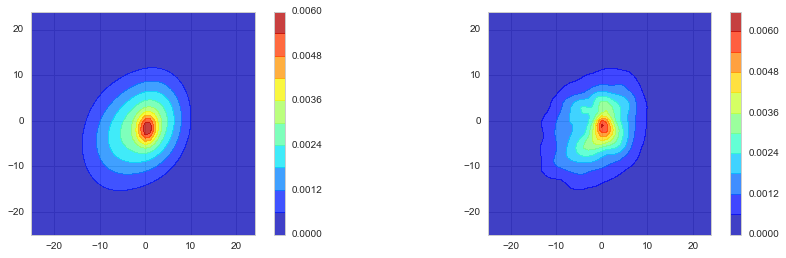

In [51]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [52]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = arange(0, max_speed)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x_vals_OEN3_LMSE ]

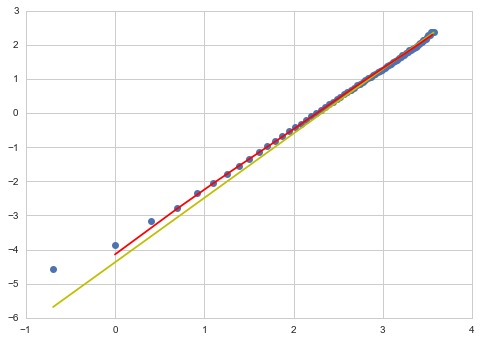

In [53]:
x = arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-', color = 'y')

# 3. OEN3 distribution, LMSE
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = array(zip(*y_)[0])
plt.plot(log(x), log(-log(1-y)),'-', color = 'r')

plt.show()

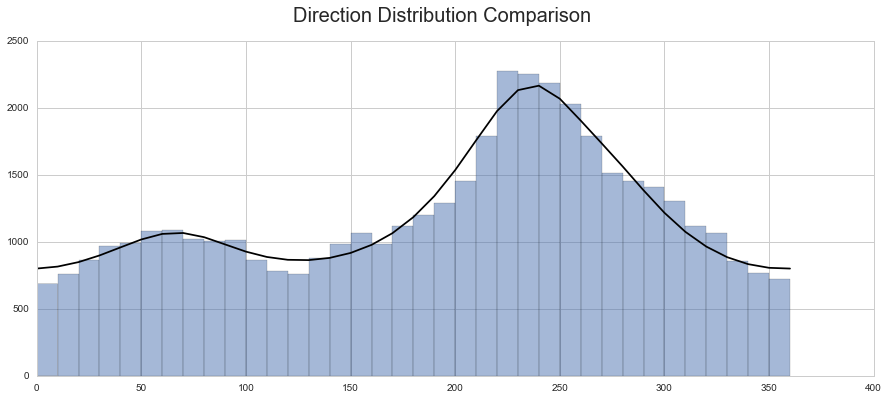

In [54]:
# Calculate Angle Distribution
x_vals = linspace(0,2*pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-pi/36, x_val+pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = array(zip(*y_vals_)[0])*len(df['dir']) 

bins=arange(0, 360 + 1, 10)
df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.show()

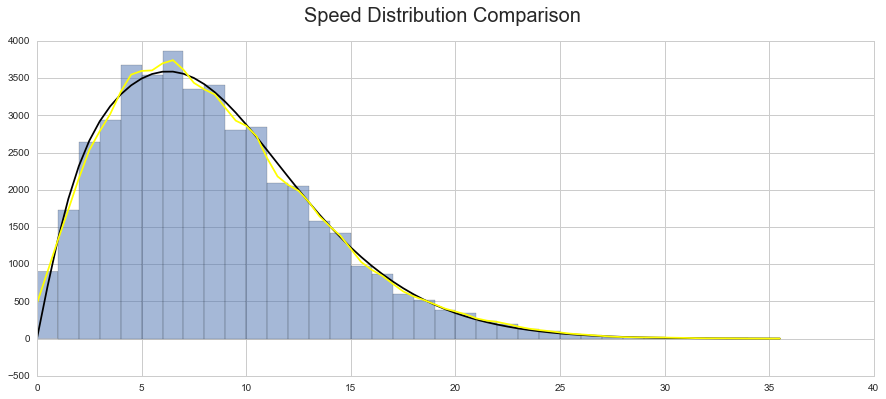

In [55]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[0, 2*pi]]) for x_val in x_vals]
y_vals = array(zip(*y_vals_)[0])*len(df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

In [56]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    max_speed = df.speed.max()
    
    count, div = np.histogram(df.speed, bins=arange(0, df.speed.max()))
    max_count = count.max()/(360/incre) *2.0
    hist_y_axis = [0, max_speed, 0, max_count]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        
        # 1. Count comparison
        # 1.1. Data Count
        fig = plt.figure(figsize=(22,4))
        ax1 = fig.add_subplot(1,4,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5)
        plt.axis(hist_y_axis)
        
        # 1.2. Model Count
        x_vals = arange(0, sub_max_speed, 0.2)
        y_vals_ =[integrate.nquad(f, 
                  [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
        plt.plot(x_vals, y_vals,'-', color='black')
    
        plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
                     fontsize = 15)
        
        # 2. CDF, Weibull plot comparison
        x =arange(0, sub_max_speed, 0.5)
        # 2.1. Data's empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_gmm = array(zip(*y_)[0])/direction_prob[0]
                
        # 2.3.1. Plot in ordinary axis
        ax3 = fig.add_subplot(1,4,2)
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        
        # 2.3.2. P-P Plot
        ax2 = fig.add_subplot(1,4,3)
        p_line = linspace(0, 1)
        plt.plot(y_gmm,y_cdf, 'o')
        plt.plot(p_line, p_line,'-')
        
        # 2.3.3. Weibull plot
        ax4 = fig.add_subplot(1,4,4)
        plt.plot(log(x), log(-log(1-y_cdf)),'o')
        plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'r')
        plt.show()
        
        diff = abs(y_cdf - y_gmm)
        max_diff_array.append([angle, diff.max(), x[diff.argmax()]])
        print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]
    return max_diff_array

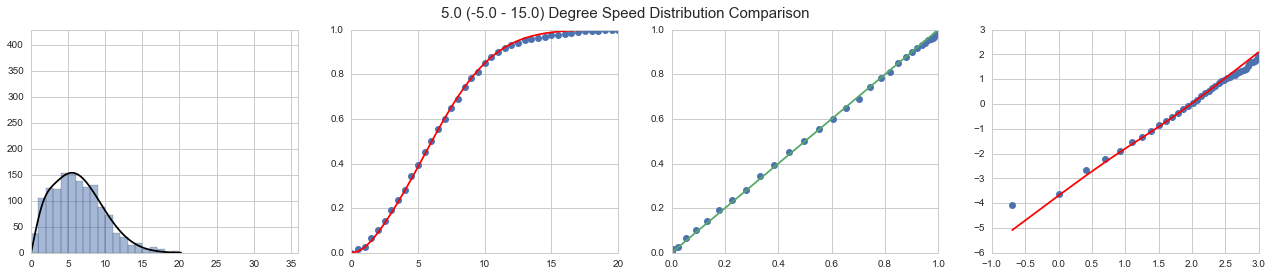

0.0153369941724 14.0 0.977818956654


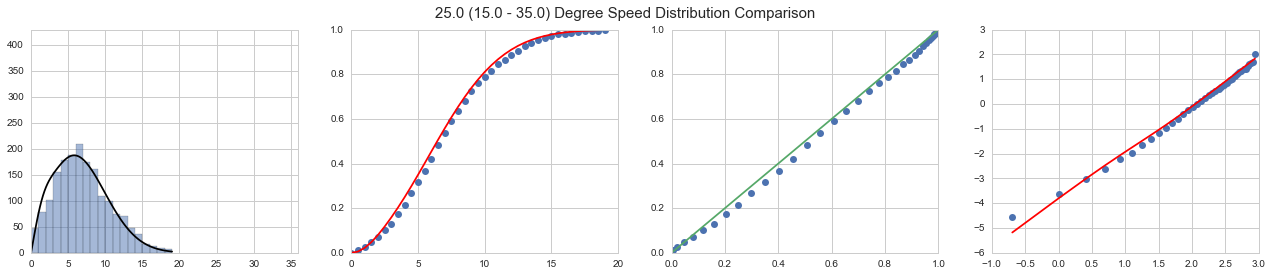

0.0343530182734 5.0 0.349375439798


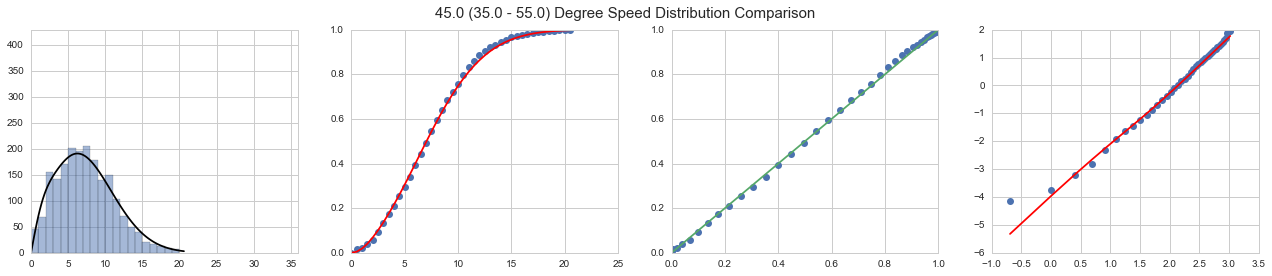

0.0230338069156 11.5 0.838272725748


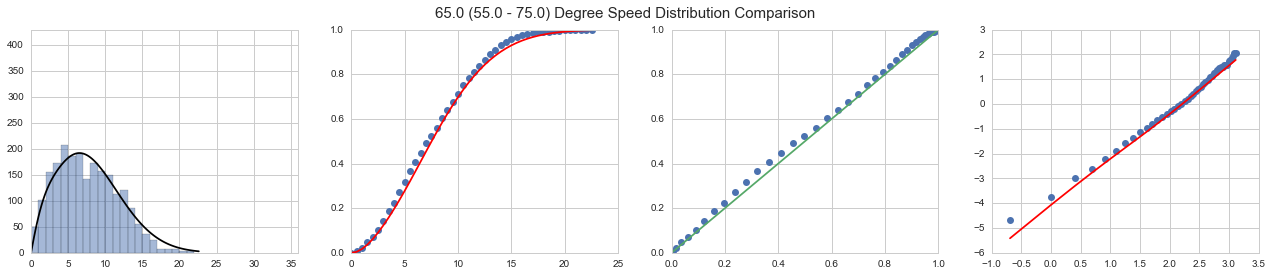

0.0449349979167 5.5 0.320726254984


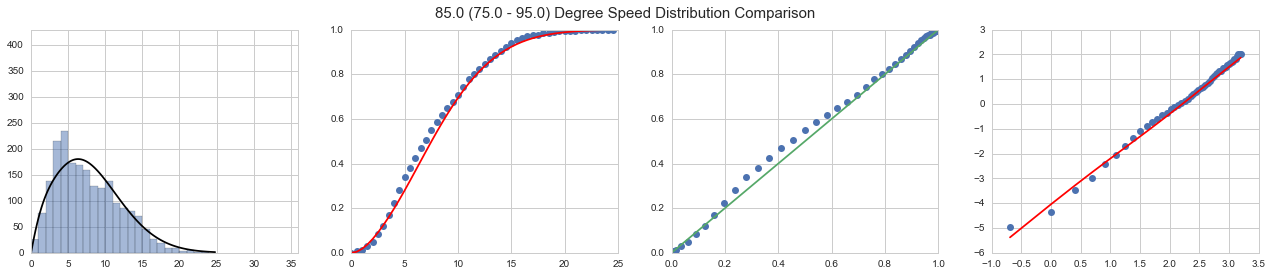

0.0586181776561 5.0 0.279941351986


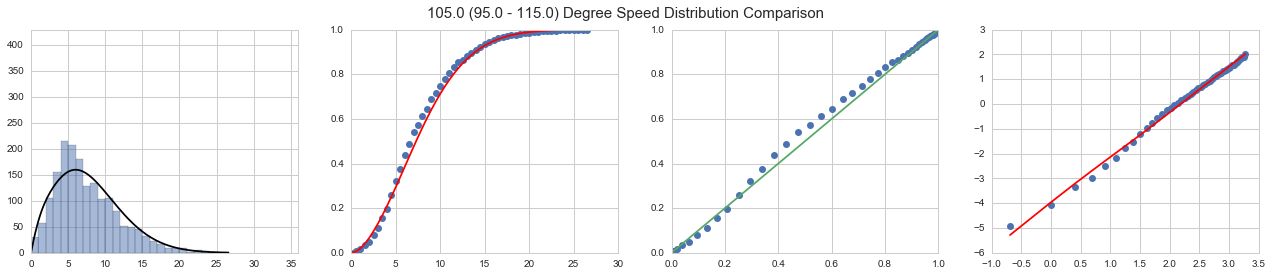

0.0653201368179 7.0 0.475020772273


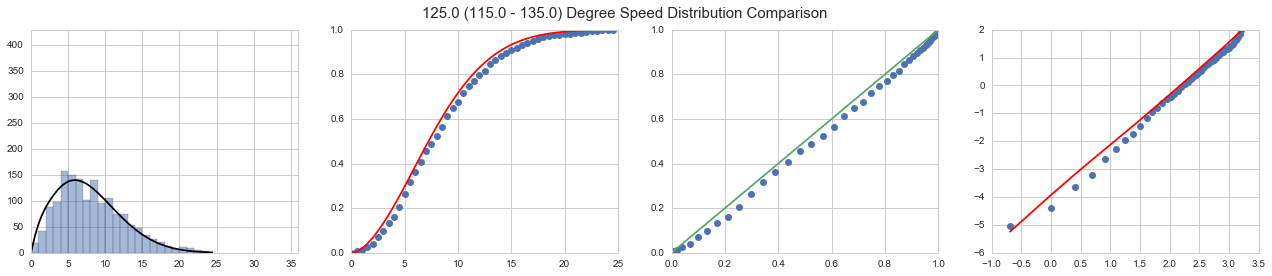

0.0490833335604 4.0 0.210838408871


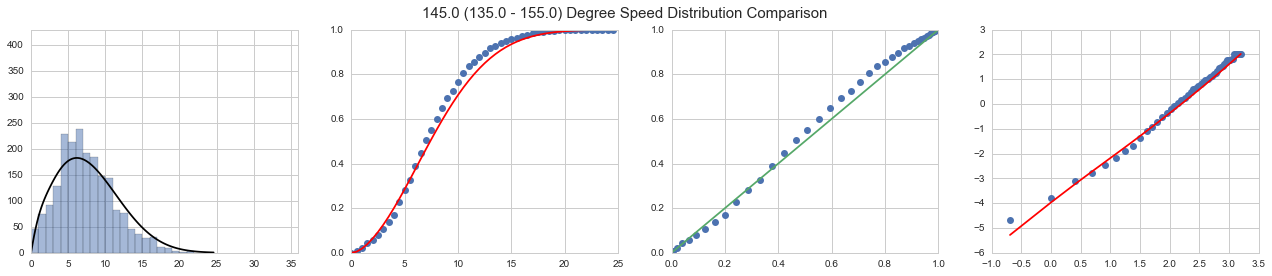

0.0655146298501 11.0 0.771533413736


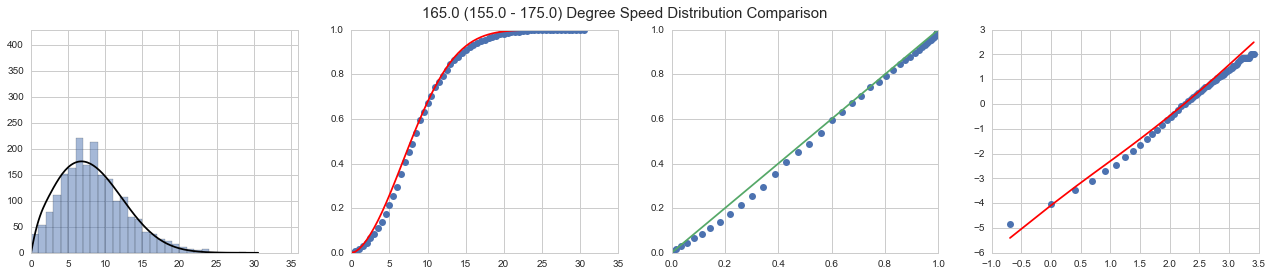

0.0474317112845 6.0 0.342863687451


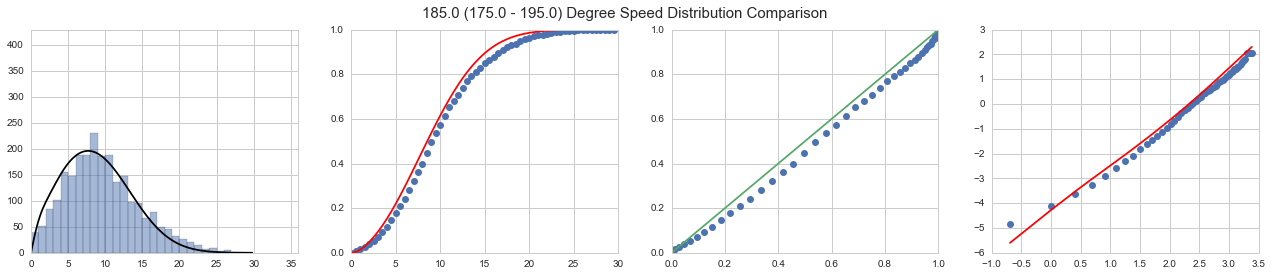

0.0583754119308 8.0 0.45687478667


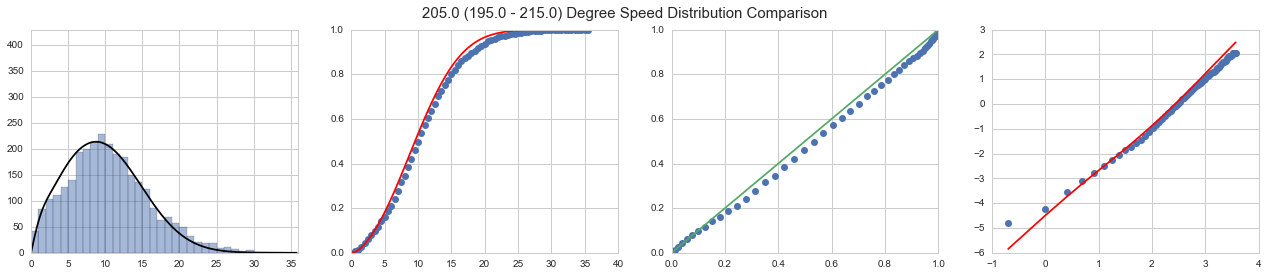

0.0400549707492 9.0 0.459543567847


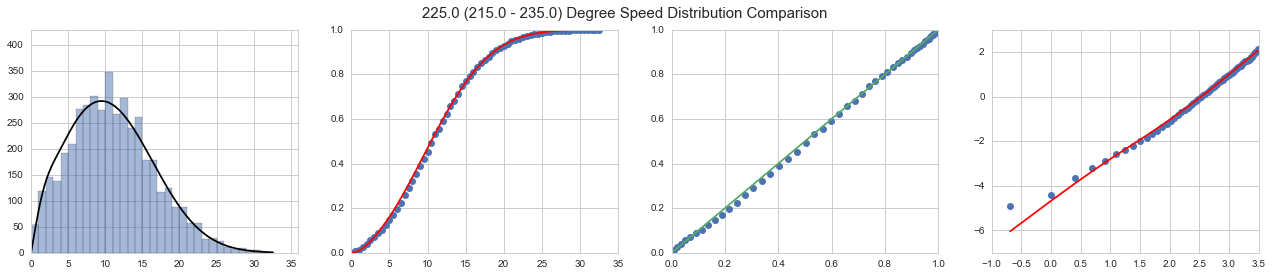

0.0214995818808 6.5 0.244651288867


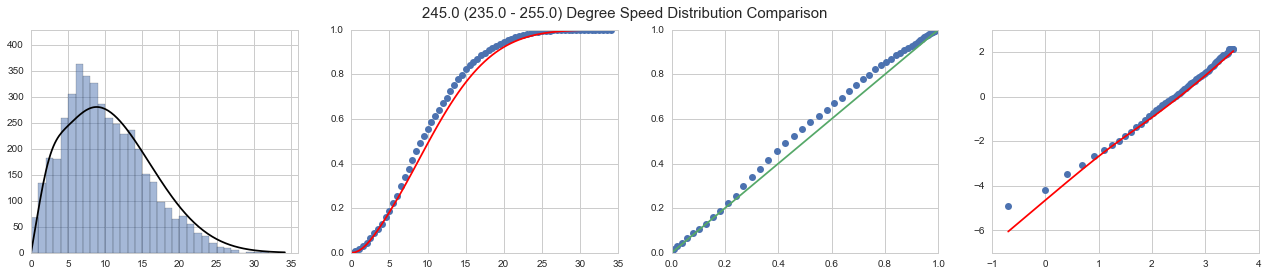

0.0676246856155 9.5 0.457437686805


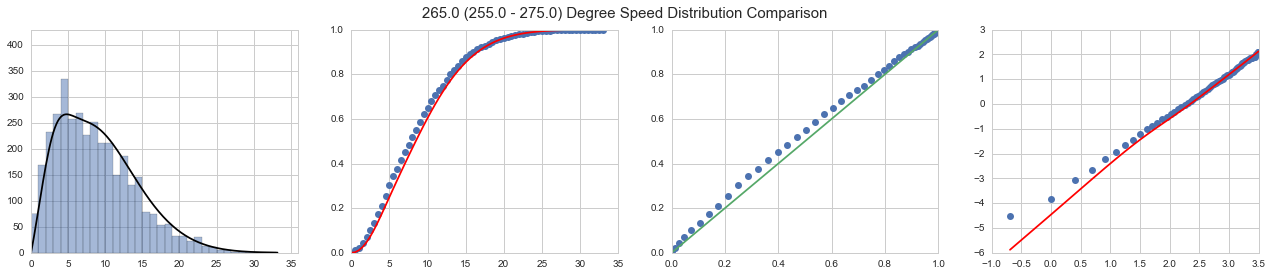

0.0556957907865 7.0 0.397363132247


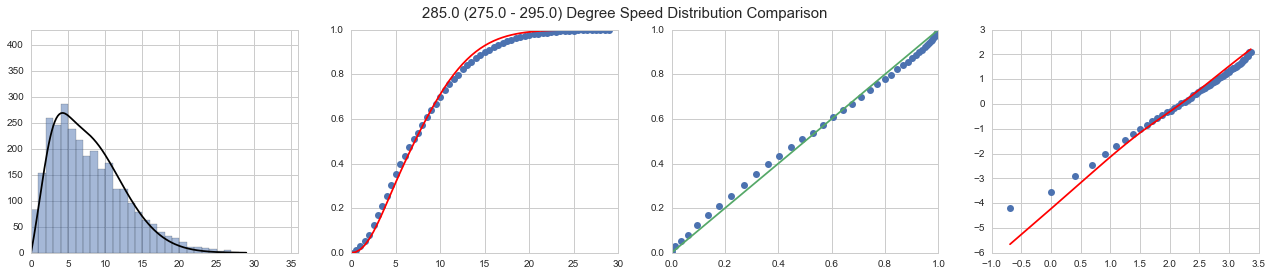

0.0372184376356 5.0 0.316005156329


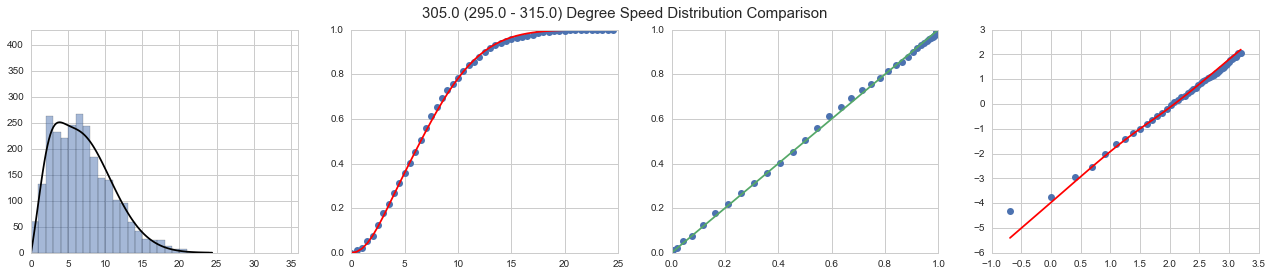

0.0215174821955 8.0 0.633370621456


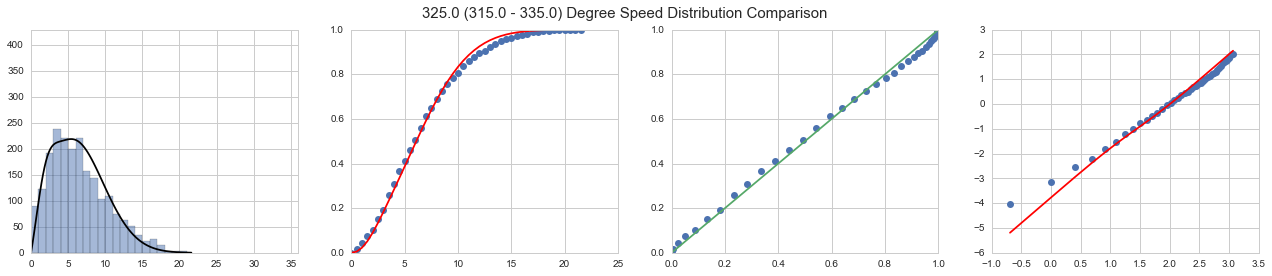

0.0351385629603 12.5 0.939991084368


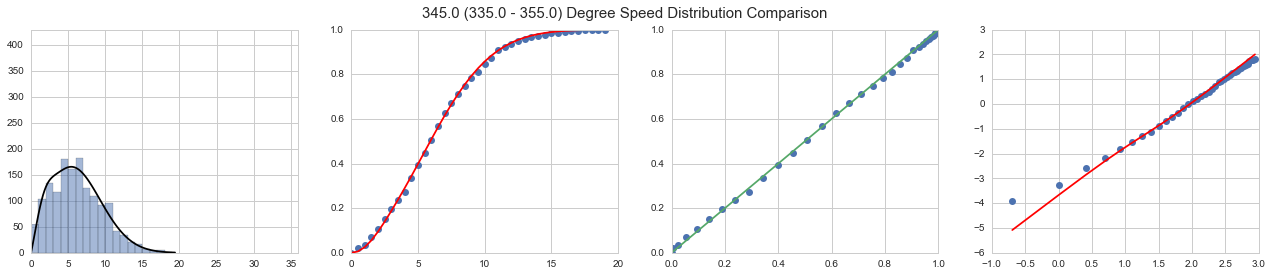

0.0185072200289 9.5 0.827074823777


In [57]:
if cn_database:
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 22.5)
else: 
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 20)

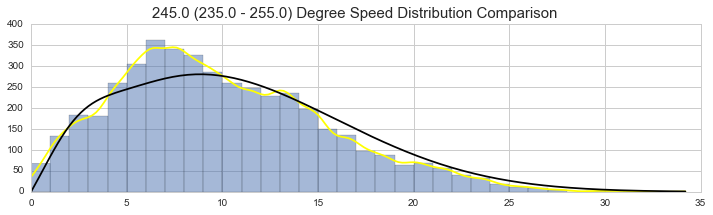

In [58]:
max_diff_element = max(max_diff_array, key=lambda x: x[1])
angle =  max_diff_angle = max_diff_element[0]
incre = 20

# Select data from observation
angle_radian, incre_radian = radians(angle), radians(incre)  
start_angle, end_angle = angle-incre/2, angle+incre/2
sub_df, max_speed = select_df_by_angle(df, start_angle, end_angle)

x_vals = arange(0, max_speed, 0.2)

# 1. Observation
sub_df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(12, 3))

# 2. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))*len(sample) 
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 3. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)
plt.show()

## Bootstrap, to see the variance of each sector

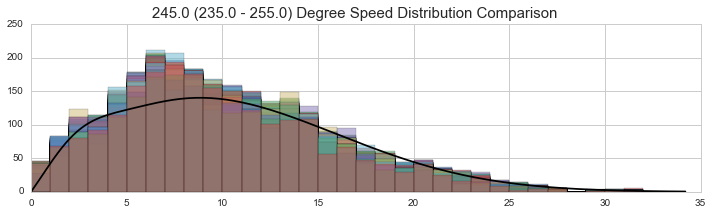

In [59]:
FRACTION = 0.5 

x_vals = arange(0, max_speed, 0.2)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2 * FRACTION
plt.plot(x_vals, y_vals,'-', color='black')

bins = arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)

0.0674670719961 10.0 0.488995513038


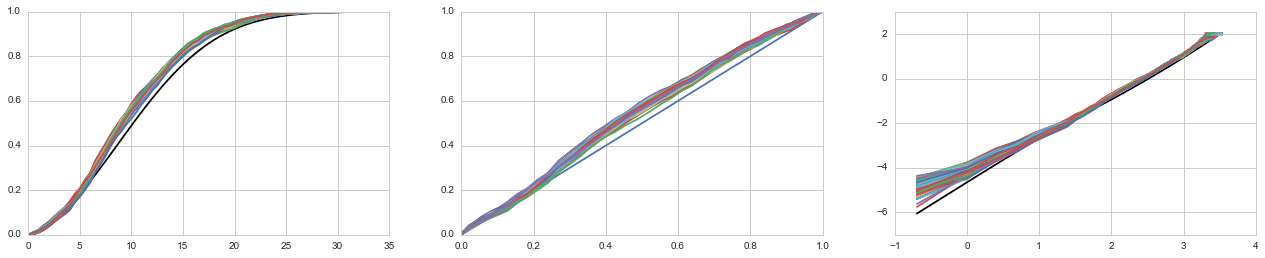

In [60]:
fig = plt.figure(figsize=(22,4))

x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,3,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax2 = fig.add_subplot(1,3,2) 
p_line = linspace(0, 1)
plt.plot(p_line, p_line,'-')

ax3 = fig.add_subplot(1,3,3) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    ax1 = fig.add_subplot(1,3,1) 
    plt.plot(x, y_cdf,'-')

    ax2 = fig.add_subplot(1,3,2) 
    plt.plot(y_gmm, y_cdf, '-')

    ax3 = fig.add_subplot(1,3,3) 
    plt.plot(log(x), log(-log(1-y_cdf)),'-')
    
diff = abs(y_cdf - y_gmm)
print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]

# Cross Validation, to check the number of ellipse to be fitted

In [ ]:
from sklearn.cross_validation import train_test_split, KFold
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error', print_result = False):
    # 1. Create Input, speed_set
    sample = sub_speed_set = array(zip(df.x, df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = exp(kde.score_samples(points))

    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf, print_result)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

In [ ]:
## 5-fold cross validation
CV_result_all =[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in xrange(1,6):
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) # each number of gaussian, fit 4 times

    CV_result = []
    for train_index, test_index in kf:
        sub_df = df.iloc[train_index]
        sub_df_test = df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result, 
                                            count = len(sub_df))
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test, 
                                            count = len(sub_df_test))
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        
        CV_result.append(gof_test)
        
    CV_result_all.append(CV_result)

Number of train/test dataset 32555.25 10851.75
  
Number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.053538,0.045318,6.397774e-08,0.041326,0.430467,0.921944
gof_test,0.059455,0.044675,6.913764e-08,0.043832,0.447816,0.917493


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.053949,0.046953,6.455726e-08,0.041513,0.432412,0.921237
gof_test,0.067645,0.048518,7.215643e-08,0.044046,0.456687,0.912681


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.053722,0.046933,6.417225e-08,0.041389,0.431121,0.921706
gof_test,0.061688,0.050228,6.732881e-08,0.041235,0.441742,0.917521


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.053769,0.045455,6.361499e-08,0.041209,0.429245,0.922386
gof_test,0.062446,0.041393,5.949896e-08,0.040039,0.415113,0.926493


  
Number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.031838,0.021542,1.564591e-08,0.020437,0.212876,0.980911
gof_test,0.041282,0.022470,1.852649e-08,0.022455,0.231831,0.977308


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.031174,0.022362,1.563840e-08,0.020432,0.212825,0.980920
gof_test,0.042419,0.021303,1.944271e-08,0.022497,0.236842,0.977055


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.031598,0.021867,1.570969e-08,0.020478,0.213309,0.980833
gof_test,0.042305,0.022710,1.979749e-08,0.023191,0.239652,0.975449


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.032167,0.022061,1.558561e-08,0.020397,0.212465,0.980985
gof_test,0.039485,0.023779,1.968425e-08,0.022793,0.238853,0.976028


  
Number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.021451,0.013022,1.182508e-08,0.017767,0.185066,0.985573
gof_test,0.032991,0.017531,1.782883e-08,0.020975,0.227511,0.978447


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.020201,0.009039,1.144712e-08,0.017481,0.182085,0.986034
gof_test,0.032104,0.017631,1.870558e-08,0.022965,0.232707,0.977443


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.021783,0.010871,1.163937e-08,0.017627,0.183607,0.985799
gof_test,0.030255,0.009856,1.386766e-08,0.018375,0.200471,0.983402


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.020491,0.008707,1.144077e-08,0.017476,0.182034,0.986042
gof_test,0.029807,0.015320,1.509765e-08,0.021362,0.208854,0.981165


  
Number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.033891,0.013221,8.598171e-09,0.015150,0.157808,0.989510
gof_test,0.039495,0.011811,1.172423e-08,0.018485,0.184362,0.985775


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.034170,0.013298,8.631790e-09,0.01518,0.158116,0.989469
gof_test,0.051111,0.012364,1.162703e-08,0.01746,0.183301,0.985761


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.04469,0.015377,8.614641e-09,0.015164,0.157959,0.989490
gof_test,0.06744,0.018951,1.307286e-08,0.018505,0.194525,0.984148


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.039861,0.015576,8.549001e-09,0.015107,0.157356,0.989570
gof_test,0.052459,0.016972,1.172125e-08,0.017266,0.184434,0.985772


  
Number of gaussian 5


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.010898,0.004739,3.452661e-09,0.009600,0.100001,0.995788
gof_test,0.019599,0.011755,8.557696e-09,0.015835,0.157609,0.989183


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.009821,0.004361,3.339400e-09,0.009442,0.098347,0.995926
gof_test,0.016994,0.009336,6.231027e-09,0.012549,0.134067,0.992586


In [ ]:
for idx, gof_group in enumerate(CV_result_all):
    print 'number of gaussian', idx+1
    display(pd.DataFrame(gof_group))

In [ ]:
mean_gof_all = []
for idx, gof_group in enumerate(CV_result_all):
    mean_gof = np.mean(pd.DataFrame(gof_group))
    mean_gof_all.append(mean_gof)
mean_gof_all = pd.DataFrame(mean_gof_all)
mean_gof_all

In [ ]:
x = arange(1,6)
for column in ['R_square','Chi_square', 'K_S']:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 3)
    plt.plot(x, mean_gof_all[column],'-')
    plt.suptitle(column)
    plt.show()